In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.resnet import ResNet50 , preprocess_input , decode_predictions
from keras.preprocessing import image
from keras.models import Model , load_model
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense , Dropout , Embedding , LSTM
from keras.layers.merging import add

## Data Collection

In [67]:
# Read text captions
def readTextFile(path) :
    with open(path) as f :
        captions = f.read()
    return captions

In [68]:
captions = readTextFile("data\Flickr8k_text\Flickr8k.token.txt")
captions = captions.split("\n")[:-1]
print(len(captions))

40460


In [69]:
#Dictionary to Map each image with the list of captions it has
# key is image id , value is list of captions
descriptions = {}
for x in captions :
    first,second = x.split('\t')
    img_name = first.split(".")[0]
    # if image id is already present or not
    if descriptions.get(img_name) is None :
        descriptions[img_name] = []
    descriptions[img_name].append(second)

In [70]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [71]:
# IMG_PATH = "C:\\Users\\prach\\PycharmProjects\\ImageCaptionGenerator\\data\\Flickr8k_Dataset\\Flicker8k_Dataset"
# import cv2
# import matplotlib.pyplot as plt
# img = cv2.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
# # img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
# plt.imshow(img)
# plt.show()

IMG_PATH = "C:\\Users\\prach\\PycharmProjects\\ImageCaptionGenerator\\data\\Flickr8k_Dataset\\Flicker8k_Dataset\\1000268201_693b08cb0e.jpg"
import cv2
path = r'C:\Users\Rajnish\Desktop\geeksforgeeks.png'
img = cv2.imread(IMG_PATH)
cv2.imshow('image', img)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Data Cleaning

In [72]:
# dont remove stopwords -> otherwise model will not make correct english
# dont use stemming -> then model will only learn stemmed words

# lower all words , remove number , remove punctuations -> reduce vocab size -> less overfitting , less computation

import re

def clean_text(sentence) :
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," " , sentence)
    sentence = sentence.split()

    # remove words with length as 1
    sentence = [s for s in sentence if len(s) > 1]
    sentence = " ".join(sentence)
    return sentence

clean_text("A cat is sitting over the house number 64 @  yo")

'cat is sitting over the house number yo'

In [73]:
#  modify all the captions i.e - cleaned captions

for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc_list[i] = clean_text(desc_list[i])

descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [74]:
# Write the data to text file
with open("descriptions.txt"  , "w") as f :
    f.write(str(descriptions))

In [75]:
# Creating vocab
# vocab creation -> set of all unique words model can predict
# finding the unique vocabulary

vocabulary = set()

for key in descriptions.keys():
    [vocabulary.update(i.split()) for i in descriptions[key]]

print('Vocabulary Size: %d' % len(vocabulary))

Vocabulary Size: 8424


In [76]:
#  ALl words in description dictionary
all_vocab =  []

for key in descriptions.keys():
    [all_vocab.append(i) for des in descriptions[key] for i in des.split()]

print('Vocabulary Size: %d' % len(all_vocab))
print(all_vocab[:15])

Vocabulary Size: 373837
['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', 'girl']


In [77]:
#  count the frequency of each word, sort them and discard the words having frequency lesser than threshold value

import collections


counter= collections.Counter(all_vocab)

dic_ = dict(counter)

threshelod_value = 10

sorted_dic = sorted(dic_.items(), reverse=True, key = lambda x: x[1])
sorted_dic = [x for x in sorted_dic if x[1]>threshelod_value]
all_vocab = [x[0] for x in sorted_dic]

In [78]:
len(all_vocab)

1845

## Loading Training Testing Data

In [79]:
# TrainImagesFile
f = open("data\Flickr8k_text\Flickr_8k.trainImages.txt")
train = f.read()
f.close()

In [80]:
train  = [e.split(".")[0] for e in train.split("\n")[:-1]]

In [81]:
train

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87',
 '218342358_1755a9cce1',
 '2501968935_02f2cd8079',
 '2699342860_5288e203ea',
 '2638369467_8fc251595b',
 '2926786902_815a99a154',
 '2851304910_b5721199bc',
 '3423802527_94bd2b23b0',
 '3356369156_074750c6cc',
 '2294598473_40637b5c04',
 '1191338263_a4fa073154',
 '2380765956_6313d8cae3',
 '3197891333_b1b0fd1702',
 '3119887967_271a097464',
 '2276499757_b44dc6f8ce',
 '2506892928_7e79bec613',
 '2187222896_c206d63396',
 '2826769554_85c90864c9',
 '3097196395_ec06075389',
 '3603116579_4a28a932e2',
 '3339263085_6db9fd0981',
 '2532262109_87429a2cae',
 '2076906555_c20dc082db',
 '2502007071_82a8c639cf',
 '3113769557_9edbb8275c',
 '3325974730_3ee192e4ff',
 '1655781989_b15ab4cbff',
 '1662261486_db967930de',
 '2410562803_56ec09f41c',
 '2469498117_b4543e1460',
 '69710415_5c2bfb1058',
 '3414734842_beb543f400',
 '3006217970_90b42e6b27',
 '2192411521_9c7e488c5e',
 '3535879138_928

In [82]:
# TestImagesFile
f = open("data\Flickr8k_text\Flickr_8k.testImages.txt")
test = f.read()
f.close()

In [83]:
test  = [e.split(".")[0] for e in test.split("\n")[:-1]]

In [84]:
test

['3385593926_d3e9c21170',
 '2677656448_6b7e7702af',
 '311146855_0b65fdb169',
 '1258913059_07c613f7ff',
 '241347760_d44c8d3a01',
 '2654514044_a70a6e2c21',
 '2339106348_2df90aa6a9',
 '256085101_2c2617c5d0',
 '280706862_14c30d734a',
 '3072172967_630e9c69d0',
 '3482062809_3b694322c4',
 '1167669558_87a8a467d6',
 '2847615962_c330bded6e',
 '3344233740_c010378da7',
 '2435685480_a79d42e564',
 '3110649716_c17e14670e',
 '2511019188_ca71775f2d',
 '2521770311_3086ca90de',
 '2723477522_d89f5ac62b',
 '2218609886_892dcd6915',
 '3745451546_fc8ec70cbd',
 '2844018783_524b08e5aa',
 '3100251515_c68027cc22',
 '2207244634_1db1a1890b',
 '2943023421_e297f05e11',
 '3286822339_5535af6b93',
 '2479652566_8f9fac8af5',
 '1394368714_3bc7c19969',
 '872622575_ba1d3632cc',
 '2309860995_c2e2a0feeb',
 '241347204_007d83e252',
 '3502343542_f9b46688e5',
 '757332692_6866ae545c',
 '2748729903_3c7c920c4d',
 '494792770_2c5f767ac0',
 '3213992947_3f3f967a9f',
 '2295750198_6d152d7ceb',
 '2358898017_24496b80e8',
 '3222055946_45f7293

In [85]:
# create train_descriptions dictionary, which will be similar to earlier one, but having only train samples
# add startseq + endseq

train_descriptions = {}

for t in train:
    train_descriptions[t] = []
    for cap in descriptions[t]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[t].append(cap_to_append)

In [86]:
train_descriptions['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

## Data Preprocessing - Images

In [87]:
#In this section, we will load our images and do some processing so that we can feed it in our network.

model = ResNet50(weights="imagenet", input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [88]:
# Create a new model, by removing the last layer (output layer of 1000 classes) from the resnet50
model_new = Model(model.input, model.layers[-2].output)

In [89]:
images = "data\\Flickr8k_Dataset\\Flicker8k_Dataset"

In [96]:
from keras.utils import load_img
from keras.utils import img_to_array
def preprocess_image(img):
    img = load_img(img, target_size=(224,224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [97]:
def encode_image(img):
    img = preprocess_image(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape(feature_vector.shape[1],)
    return feature_vector

In [99]:
start = time()

encoding_train = {}

for ix, img in enumerate(train):

    img = "data/Flickr8k_Dataset/Flicker8k_Dataset/{}.jpg".format(train[ix])
    print(img)
    encoding_train[img[len(images):]] = encode_image(img)

    if ix%100==0:
        print("Encoding image- "+ str(ix))

print("Time taken in seconds =", time()-start)

./data/Flickr8k_Dataset/Flicker8k_Dataset/2094543127_46d2f1fedf.jpg
1/1 [==============================] - 0s 68ms/step
./data/Flickr8k_Dataset/Flicker8k_Dataset/3004291289_c4892898ae.jpg
1/1 [==============================] - 0s 68ms/step
./data/Flickr8k_Dataset/Flicker8k_Dataset/3562169000_6aa7f1043d.jpg
1/1 [==============================] - 0s 71ms/step
./data/Flickr8k_Dataset/Flicker8k_Dataset/3312779887_7682db7827.jpg
1/1 [==============================] - 0s 69ms/step
./data/Flickr8k_Dataset/Flicker8k_Dataset/2832978253_8fcc72da3b.jpg
1/1 [==============================] - 0s 71ms/step
./data/Flickr8k_Dataset/Flicker8k_Dataset/2198494923_8159551be4.jpg
1/1 [==============================] - 0s 72ms/step
./data/Flickr8k_Dataset/Flicker8k_Dataset/2460126267_0deea8b645.jpg
1/1 [==============================] - 0s 73ms/step
./data/Flickr8k_Dataset/Flicker8k_Dataset/3119696225_b289efaec8.jpg
1/1 [==============================] - 0s 68ms/step
./data/Flickr8k_Dataset/Flicker8k_Datase

KeyboardInterrupt: 

In [102]:
encoding_train

{'/2513260012_03d33305cf.jpg': array([0.34708002, 0.5115907 , 0.08728839, ..., 1.1897295 , 0.04043845,
        0.1527107 ], dtype=float32),
 '/2903617548_d3e38d7f88.jpg': array([0.        , 0.00307797, 0.09360045, ..., 0.4310344 , 0.37985358,
        0.9165757 ], dtype=float32),
 '/3338291921_fe7ae0c8f8.jpg': array([0.76744586, 0.53422695, 0.38325185, ..., 0.02098648, 0.18429343,
        0.04270025], dtype=float32),
 '/488416045_1c6d903fe0.jpg': array([6.2481087e-01, 3.2965422e-01, 1.7821546e-04, ..., 1.2753810e+00,
        4.6392527e-01, 4.9036112e-01], dtype=float32),
 '/2644326817_8f45080b87.jpg': array([0.11555333, 0.65965396, 0.05323283, ..., 0.1439733 , 1.0179377 ,
        0.0055658 ], dtype=float32),
 '/218342358_1755a9cce1.jpg': array([1.7061833 , 0.40514746, 0.35206544, ..., 0.29408917, 0.04833036,
        0.04654433], dtype=float32),
 '/2501968935_02f2cd8079.jpg': array([0.10608295, 1.4420795 , 0.04447003, ..., 0.2058717 , 0.69787604,
        1.5904311 ], dtype=float32),
 '/2

In [106]:

# Save the bottleneck train features to disk

with open("./storage/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [105]:
start = time()

encoding_test = {}

for ix, img in enumerate(test):

    img = "data/Flickr8k_Dataset/Flicker8k_Dataset/{}.jpg".format(test[ix])
    encoding_test[img[len(images):]] = encode_image(img)

    if ix%100==0:
        print("Encoding image- "+ str(ix))

print("Time taken in seconds =", time()-start)

1/1 [==============================] - 0s 221ms/step
Encoding image- 0
1/1 [==============================] - 0s 178ms/step
Encoding image- 100
1/1 [==============================] - 0s 180ms/step
Encoding image- 200
1/1 [==============================] - 0s 195ms/step
Encoding image- 300
1/1 [==============================] - 0s 173ms/step
Encoding image- 400
1/1 [==============================] - 0s 163ms/step
Encoding image- 500
1/1 [==============================] - 0s 159ms/step
Encoding image- 600
1/1 [==============================] - 0s 143ms/step
Encoding image- 700
1/1 [==============================] - 0s 137ms/step
Encoding image- 800
1/1 [==============================] - 0s 147ms/step
Encoding image- 900
1/1 [==============================] - 0s 136ms/step
Time taken in seconds = 192.52347779273987


In [107]:
# Save the bottleneck train features to disk

with open("./storage/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [108]:
# Load the train images features from disk

with open("./storage/encoded_train_images.pkl", "rb") as encoded_pickle:
    encoding_train = pickle.load(encoded_pickle)

In [109]:
# Load the test images features from disk

with open("./storage/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

## Dara Preprocessing - captions

In [110]:
"""
word_to_idx is mapping between each unique word in all_vocab to int value
and idx_to_word is vice-versa
"""


ix = 1
word_to_idx = {}
idx_to_word = {}

for e in all_vocab:
    word_to_idx[e] = ix
    idx_to_word[ix] = e
    ix +=1

In [111]:

#  need to add these 2 words as well

word_to_idx['startseq'] = 1846
word_to_idx['endseq'] = 1847

idx_to_word[1846] = 'startseq'
idx_to_word[1847] = 'endseq'

In [112]:
#  vocab_size is total vocabulary len +1 because we will append 0's as well.

vocab_size = len(idx_to_word)+1
print(vocab_size)

1848


In [113]:
all_captions_len = []

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        all_captions_len.append(len(cap.split()))

max_len = max(all_captions_len)
print(max_len)

35


## Data Preparation using Generator Function

In [114]:
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, num_photos_per_batch):

    X1, X2, y = [], [], []

    n=0

    while True:

        for key, desc_list in train_descriptions.items():
            n +=1

            photo = encoding_train[key+".jpg"]

            for desc in desc_list:

                seq = [ word_to_idx[word] for word in desc.split() if word in word_to_idx]

                for i in range(1,len(seq)):

                    in_seq = seq[0:i]
                    out_seq = seq[i]

                    in_seq = pad_sequences([in_seq], maxlen=max_len, value=0, padding='post')[0]

                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = [], [], []
                n=0

## Word Embedding

In [116]:
f = open("./GloVE/glove.6B.50d.txt", encoding='utf8')
embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float")

    embedding_index[word] = coefs

f.close()

## Converting words into vectors Directly - (Embedding Layer Output)

In [117]:
def get_embedding_output():

    emb_dim = 50
    embedding_output = np.zeros((vocab_size,emb_dim))

    for word, idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)

        if embedding_vector is not None:
            embedding_output[idx] = embedding_vector

    return embedding_output


embedding_output = get_embedding_output()

embedding_output.shape

(1848, 50)

## Model Architecture

In [118]:
# image feature extractor model

input_img_fea = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_fea)
inp_img2 = Dense(256, activation='relu')(inp_img1)

# partial caption sequence model

input_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

decoder1 = add([inp_img2 , inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Merge 2 networks
model = Model(inputs=[input_img_fea, input_cap], outputs=outputs)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 50)       92400       ['input_4[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_3[0][0]']                
                                                                                            

In [119]:
model.layers[2].set_weights([embedding_output])
model.layers[2].trainable = False

model.compile(loss="categorical_crossentropy", optimizer="adam")

## Train Our Model

In [158]:
epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath
for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, number_pics_per_bath)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

KeyError: '2513260012_03d33305cf.jpg'

In [148]:
model = load_model("./model_weights/model_9.h5")

## Predictions

In [149]:
def predict_caption(photo):
    in_text = "startseq"

    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')

        ypred =  model.predict([photo,sequence])
        ypred = ypred.argmax()
        word = idx_to_word[ypred]
        in_text+= ' ' +word

        if word =='endseq':
            break


    final_caption =  in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption)

    return final_caption

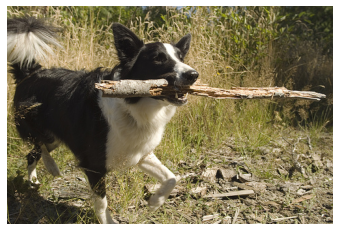

1/1 [==============================] - 0s 47ms/step
black and white dog is running on the grass


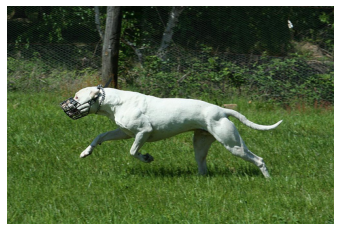

1/1 [==============================] - 0s 44ms/step
brown dog is running on grass


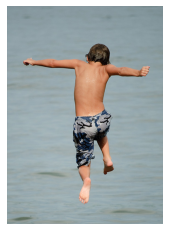

1/1 [==============================] - 0s 47ms/step
young boy in swimming trunks is running in the water


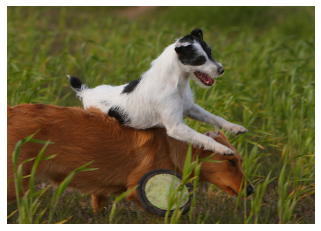

1/1 [==============================] - 0s 46ms/step
two dogs are playing with tennis ball in field


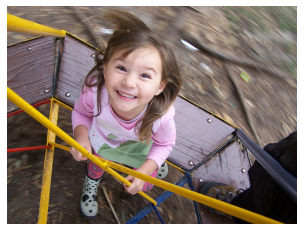

1/1 [==============================] - 0s 43ms/step
little boy in blue shirt and blue shorts is swinging on swing


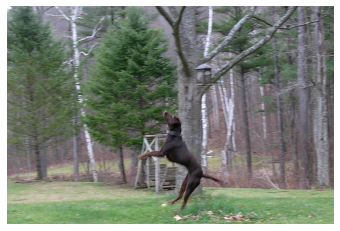

1/1 [==============================] - 0s 57ms/step
black dog jumps over fence in the grass


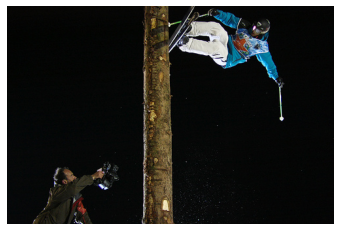

1/1 [==============================] - 0s 44ms/step
skateboarder in the air over the railing


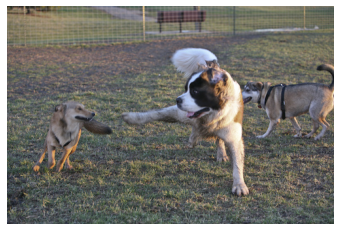

1/1 [==============================] - 0s 44ms/step
two dogs are playing with each other in the grass


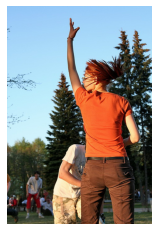

1/1 [==============================] - 0s 44ms/step
boy in white shirt is walking on the grass


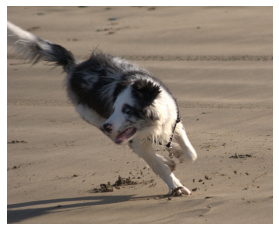

1/1 [==============================] - 0s 45ms/step
dog runs on the sand


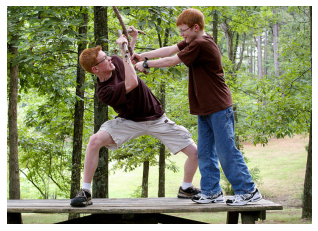

1/1 [==============================] - 0s 52ms/step
boy in blue shirt and cast shoes is sitting on bench


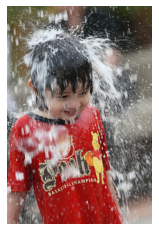

1/1 [==============================] - 0s 50ms/step
two children are playing in water


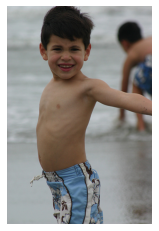

1/1 [==============================] - 0s 40ms/step
young boy in blue bathing suit is jumping off pier


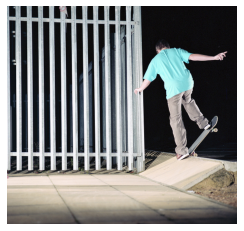

1/1 [==============================] - 0s 44ms/step
man in black shirt and jeans skateboards on skateboard


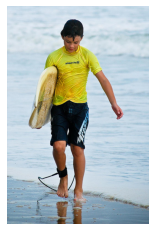

1/1 [==============================] - 0s 39ms/step
young girl in blue shorts is running on the beach


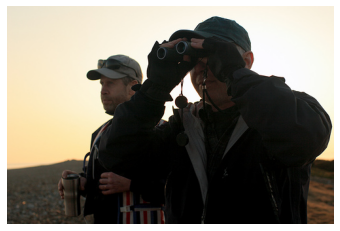

1/1 [==============================] - 0s 38ms/step
man with camera is standing on top of mountain


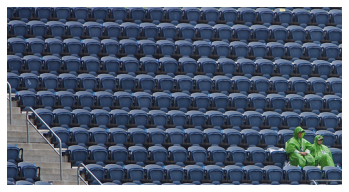

1/1 [==============================] - 0s 40ms/step
two men in red shirts are sitting in front of an audience


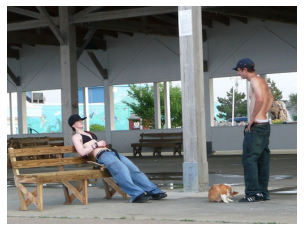

1/1 [==============================] - 0s 50ms/step
man and woman sit on bench with their arms around the camera


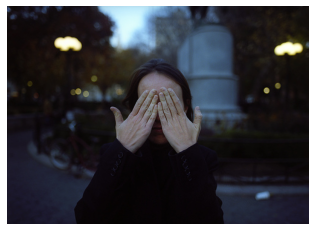

1/1 [==============================] - 0s 47ms/step
woman in black jacket is standing on the phone


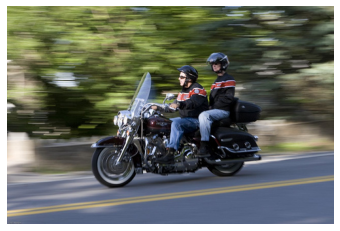

1/1 [==============================] - 0s 39ms/step
man rides motorcycle on dirt track


In [159]:
for i in range(20):
    rn =  np.random.randint(0, 1000)
    img_name = list(encoding_test.keys())[rn]
    photo = encoding_test[img_name].reshape((1,2048))

    i = plt.imread(images+img_name)
    plt.imshow(i)
    plt.axis("off")
    plt.show()

    caption = predict_caption(photo)
    print(caption)